In [1]:
import os
print(os.getcwd())

# data_dir = os.getcwd()+"/paper/"
# print(data_dir)

os.chdir("/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo")

from examples.paper.initialize import *
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

/Users/Jennifer/Desktop/CSE291B/actionable-recourse-git-master-repo/examples


# Read in Data

In [2]:
data_name = 'german'
data_file = data_dir / ('%s_processed.csv' % data_name)
output_dir = results_dir /  data_name

## load and process data
data_df = pd.read_csv(data_file).reset_index(drop=True)
# german_df = german_df.assign(isMale=lambda df: (df['Gender']=='Male').astype(int))#.drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1)
y = data_df['GoodCustomer']
X = (data_df.drop('GoodCustomer', axis=1)
     .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1))

# Train classifier

In [3]:
## Train and generate AUCs
## grid search
clf = LogisticRegression(max_iter=1000, solver='lbfgs')
grid = GridSearchCV(
        clf, param_grid={'C': np.logspace(-4, 3)},
        cv=10,
        scoring='roc_auc',
        return_train_score=True
        )
grid.fit(X, y)
clf = grid.best_estimator_

# Create Actionset

In [4]:
## set up actionset
gender_weight = data_df.assign(c = 1).groupby('Gender')['c'].transform(lambda s: s * 1. / len(s))
X_gender_balanced = X.sample(n = len(X)*3, replace=True, weights=gender_weight)
action_set = ActionSet(X = X_gender_balanced)
action_set['Age'].mutable = False
action_set['Single'].mutable = False
action_set['JobClassIsSkilled'].mutable = False
action_set['ForeignWorker'].mutable = False
action_set['OwnsHouse'].mutable = False
action_set['RentsHouse'].mutable = False
action_set['CriticalAccountOrLoansElsewhere'].step_direction = -1
action_set['CheckingAccountBalance_geq_0'].step_direction = 1

# Run Audit

In [5]:
# median score
np.median(clf.predict_proba(X)[:, 1])

0.7233469573489756

In [6]:
# cache classifier
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
action_set.align(coefficients=coefficients)

# audit
p = .72 ## for now we'll set this to the median score, but we could set this to any threshold we want.
auditor = RecourseAuditor(
    action_set,
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
audit_results = auditor.audit(X = X)

# Visualize

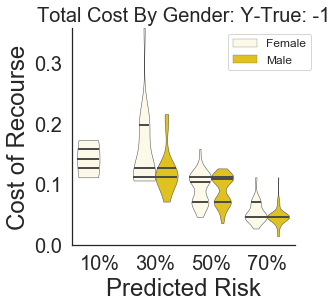

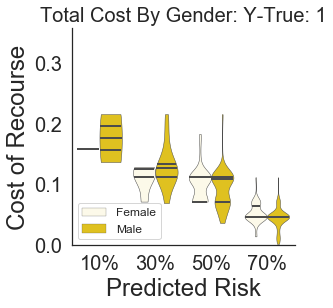

In [7]:
scores = pd.Series(clf.predict_proba(X)[:, 1])
matching_df = pd.concat([
    data_df[['GoodCustomer', 'Gender']],
    audit_results[['cost']],
    scores.to_frame('y_pred')
    ], axis=1).replace(np.inf, np.nan).dropna()


####### Matching 2: Control for Y=+/- 1
matching_df['y_pred_bin'] = pd.cut(
    matching_df['y_pred'],
    bins=np.arange(0, .9, .2)
)


bins = matching_df['y_pred_bin'].unique()

max_cost = matching_df['cost'].max()
plt.rc("font", size=20)
for y_true in [-1, 1]:
    plt.figure(figsize=(4, 4))
    ax = sns.violinplot(
        x='y_pred_bin',  y='cost', hue='Gender',
        data=matching_df.loc[lambda df: df['GoodCustomer'] == y_true].sort_values('Gender'),
        linewidth = 0.5, cut=0, background='white',
        scale = 'width', color="gold",  inner = 'quartile'
    )
    ax.set_xticklabels(["10%", "30%", "50%", "70%"])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_ylim((0, max_cost))
    plt.title('Total Cost By Gender: Y-True: %d' % y_true, fontsize=20)
    plt.ylabel('Cost of Recourse')
    plt.xlabel('Predicted Risk' )

    if y_true == -1:
        plt.legend(fontsize=12., loc='upper right', bbox_to_anchor=(1.1, 1))
    else:
        plt.legend(fontsize=12., loc='lower left')#, bbox_to_anchor=(1.1, 1))
    for l in ax.lines:
        l.set_linewidth(2.)
        l.set_linestyle('-')
        l.set_solid_capstyle('butt')

    plt.show() 

## get accuracy

In [26]:
print("total number of data points in testing set: ")
print(matching_df.shape)
print("total number of correct datapoints in testing set: ")
print(matching_df.loc[lambda df: df['GoodCustomer'] == -1].shape)
print(matching_df.loc[lambda df: df['GoodCustomer'] == 1].shape)

print(clf.predict(X))

print("testing accuracy: ")
print((219+270)/matching_df.shape[0])

total number of data points in testing set: 
(489, 5)
total number of correct datapoints in testing set: 
(219, 5)
(270, 5)
[ 1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1 -1  1  1  1 -1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1 -1  1
  1 -1  1  1 -1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1
  1 -1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1 -1
  1  1 -1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1 -1 -1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1 -1  1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1


# Generate Flipsets

In [8]:
from IPython.display import HTML

In [9]:
# ### get flipset
gender = "Male"
individuals = (matching_df
    .loc[lambda df: df['Gender'] == gender]
    .loc[lambda df: df['y_pred'] < .3]
    .loc[lambda df: df['y_pred'] > .1]
    .loc[lambda df: df['GoodCustomer'] == 1]
    )
i = individuals.index[1]

fb = Flipset(
    x = X.loc[i].values, 
    action_set = action_set, 
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 6)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_MIP_Cuts_Covers                         -1
CPXPARAM_MIP_Display                             1
CPXPARAM_MIP_Cuts_MIRCut                         -1
CPXPARAM_MIP_Pool_Capacity                       100
CPXPARAM_MIP_Pool_Replace                        2
CPXPARAM_MIP_Cuts_ZeroHalfCut                    -1
CPXPARAM_MIP_Cuts_LocalImplied                   3
CPXPARAM_MIP_Limits_RepairTries                  20
CPXPARAM_MIP_Tolerances_AbsMIPGap                2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_MIPGap                   2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_Integrality              0
MIP Presolve eliminated 13 redundant SOS constraints.
Tried aggregator 2 times.
MIP Presolve eliminated 1 rows and 0 columns.
Aggregat

Repair heuristic found nothing.
Best integer =   4.184184e+01  Node =     295  Best node =   4.179179e+01

Gomory fractional cuts applied:  1
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_MIP_Cuts_Covers                         -1
CPXPARAM_MIP_Display                             1
CPXPARAM_MIP_Cuts_MIRCut                         -1
CPXPARAM_MIP_Pool_Capacity                       100
CPXPARAM_MIP_Pool_Replace                        2
CPXPARAM_MIP_Cuts_ZeroHalfCut                    -1
CPXPARAM_MIP_Cuts_LocalImplied                   3
CPXPARAM_MIP_Limits_RepairTries                  20
CPXPARAM_MIP_Tolerances_AbsMIPGap                2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_MIPGap                   2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_Integrality        

Flipset with %d Items
# items: 6
x: array([0.000e+00, 1.000e+00, 2.200e+01, 2.400e+01, 3.149e+03, 4.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00])
w: ([ 3.2543e-01  3.8924e-01  1.6504e-02 -2.5275e-02 -7.5783e-05 -2.3590e-01
  5.0367e-02 -2.5560e-01  2.5478e-02  4.0323e-01 -3.2328e-01  2.5225e-01
  4.3551e-01  5.1494e-01  2.1947e-01 -5.8013e-01  7.8486e-01 -6.2129e-01
 -2.3941e-01  3.6748e-01  6.9090e-01  1.2826e-01 -1.7176e-01 -2.0157e-01
  4.1687e-01  2.3713e-01])
items: [{'cost': 30.578230736219464, 'feasible': True, 'status': 'integer optimal solution', 'costs': array([ 0.    ,  0.    ,  0.    ,  1.1956,  0.9416, 14.2135,  0.6951,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    , 13.5323,  0.    ,  0.    ,  0.    ,
       

In [10]:
HTML(fb.to_html())

In [11]:
gender = 'Female'
individuals = (matching_df
    .loc[lambda df: df['Gender'] == gender]
    .loc[lambda df: df['y_pred'] < .3]
    .loc[lambda df: df['y_pred'] > .1]
    .loc[lambda df: df['GoodCustomer'] == 1]
    )
i = individuals.index[0]

fb = Flipset(
    x = X.loc[i].values, 
    action_set = action_set, 
    coefficients = coefficients,
    intercept = intercept - (np.log(p / (1. - p))),
)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 6)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_MIP_Cuts_Covers                         -1
CPXPARAM_MIP_Display                             1
CPXPARAM_MIP_Cuts_MIRCut                         -1
CPXPARAM_MIP_Pool_Capacity                       100
CPXPARAM_MIP_Pool_Replace                        2
CPXPARAM_MIP_Cuts_ZeroHalfCut                    -1
CPXPARAM_MIP_Cuts_LocalImplied                   3
CPXPARAM_MIP_Limits_RepairTries                  20
CPXPARAM_MIP_Tolerances_AbsMIPGap                2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_MIPGap                   2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_Integrality              0
MIP Presolve eliminated 14 redundant SOS constraints.
Tried aggregator 2 times.
MIP Presolve eliminated 1 rows and 0 columns.
Aggregat

Reduced MIP has 75 binaries, 4 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.19 ticks)
Probing time = 0.00 sec. (0.12 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: none, using 1 thread.

Node log . . .
Best integer =   4.268473e+01  Node =       0  Best node =   0.000000e+00
Repair heuristic found nothing.
Detecting symmetries...

Repeating presolve.
Tried aggregator 2 times.
MIP Presolve eliminated 3 rows and 60 columns.
MIP Presolve modified 2 coefficients.
Aggregator did 2 substitutions.
Reduced MIP has 7 rows, 17 columns, and 36 nonzeros.
Reduced MIP has 15 binaries, 2 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.07 ticks)
Probing fixed 1 vars, tightened 0 bounds.
Probing time = 0.01 sec. (0.01 ticks)
Cover probing fixed 0 vars, tightened 18 bounds.
Tried aggregator 1 time.
MIP Presolve eliminated 7 rows and 17 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01

CPXPARAM_MIP_Pool_Replace                        2
CPXPARAM_MIP_Cuts_ZeroHalfCut                    -1
CPXPARAM_MIP_Cuts_LocalImplied                   3
CPXPARAM_MIP_Limits_RepairTries                  20
CPXPARAM_MIP_Tolerances_AbsMIPGap                2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_MIPGap                   2.2204460492503131e-16
CPXPARAM_MIP_Tolerances_Integrality              0
4 of 6 MIP starts provided solutions.
MIP start 'm2' defined initial solution with objective 43.0936.
Retaining values of one MIP start for possible repair.
MIP Presolve eliminated 14 redundant SOS constraints.
Tried aggregator 2 times.
MIP Presolve eliminated 1 rows and 0 columns.
Aggregator did 20 substitutions.
Reduced MIP has 15 rows, 79 columns, and 228 nonzeros.
Reduced MIP has 75 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.42 ticks)
Probing time = 0.00 sec. (0.15 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 15 rows, 79 columns

Flipset with %d Items
# items: 6
x: array([0.00e+00, 0.00e+00, 2.90e+01, 3.60e+01, 3.99e+03, 3.00e+00,
       2.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
       0.00e+00, 0.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
       0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
       0.00e+00, 0.00e+00])
w: ([ 3.2543e-01  3.8924e-01  1.6504e-02 -2.5275e-02 -7.5783e-05 -2.3590e-01
  5.0367e-02 -2.5560e-01  2.5478e-02  4.0323e-01 -3.2328e-01  2.5225e-01
  4.3551e-01  5.1494e-01  2.1947e-01 -5.8013e-01  7.8486e-01 -6.2129e-01
 -2.3941e-01  3.6748e-01  6.9090e-01  1.2826e-01 -1.7176e-01 -2.0157e-01
  4.1687e-01  2.3713e-01])
items: [{'cost': 42.674892905937675, 'feasible': True, 'status': 'integer optimal solution', 'costs': array([ 0.    ,  0.    ,  0.    ,  2.2188,  0.0696,  0.5819,  0.2827,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , 12.9929,  0.    , 13.5323,  0.    , 12.9967,  0.    ,
        0.    ,  0.    ,  0.    ,

In [12]:
HTML(fb.to_html())